<a href="https://www.kaggle.com/code/maksudmalik/quora-question-classification?scriptVersionId=229874260" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [2]:
import nltk
import xgboost as xgb
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_colwidth', None)

In [3]:
train_df=pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv")
test_df=pd.read_csv("/kaggle/input/quora-insincere-questions-classification/test.csv")
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [4]:
train_df.shape

(1306122, 3)

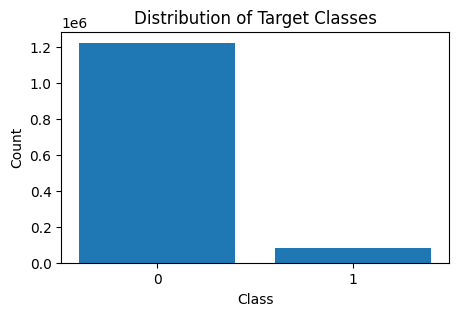

In [5]:
class_counts = train_df["target"].value_counts()
plt.figure(figsize=(5, 3))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Target Classes")
plt.xticks([0, 1])
plt.show()

In [6]:
train_inputs, val_inputs, y_train, y_val = train_test_split(train_df.question_text, train_df.target, 
                                                                        test_size=0.3, random_state=42)

# Manual Feature Extraction

In [7]:
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer(language='english')

In [8]:
def preprocess(doc):
    doc_stp=[[word for word in text.split(" ") if word.lower() not in english_stopwords]for text in doc]
    doc_stem=[[stemmer.stem(word) for word in words]for words in doc_stp]
    doc_final=[' '.join(words) for words in doc_stem]
    return doc_final
    
text_pipeline = Pipeline([
    ('preprocess', FunctionTransformer(preprocess)),
    ('vectorize', TfidfVectorizer(max_features=1000))
])

In [9]:
%%time
x_train=text_pipeline.fit_transform(train_inputs)
x_val=text_pipeline.transform(val_inputs)
x_test=text_pipeline.transform(test_df.question_text)

CPU times: user 3min 29s, sys: 2.14 s, total: 3min 32s
Wall time: 3min 32s


In [10]:
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

In [11]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
)

In [12]:
%%time
model.fit(x_train, y_train)

CPU times: user 4min 15s, sys: 579 ms, total: 4min 16s
Wall time: 1min 8s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [13]:
y_pred=model.predict(x_val)

In [14]:
f1_score(y_val, y_pred)

0.4160066299650743

# Learned Representations